from susie results, what fraction of lead vars are shared with gene within 1MB?

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D

In [45]:
# Load in tissue colors 
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)

gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

                            
gene_type_order_highlight = ['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Use a lighter/greyer version for all except new_lncRNA
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

In [46]:
gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')

/local/scratch/klawren/slrmtmp.48890488/ipykernel_16887/486780901.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')


In [47]:
egene_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL"

# load in the eSusie files
esusie = []
esusie_tissues = []
for id, row in tissue_df.iterrows():
    try:
        esusie.append(pd.read_parquet(f"{egene_results_dir}/{row['tissue_file_name']}.v11.eQTLs.SuSiE_summary.parquet"))
        esusie_tissues.append(row['tissue_file_name'])
    except:
        print(f"No eSusie results for {row['tissue_file_name']}")

No eSusie results for Artery_Aorta
No eSusie results for Artery_Coronary
No eSusie results for Artery_Femoral
No eSusie results for Artery_Tibial
No eSusie results for Brain_Anterior_cingulate_cortex_BA24
No eSusie results for Brain_Cerebellar_Hemisphere
No eSusie results for Brain_Cerebellum
No eSusie results for Brain_Cortex
No eSusie results for Brain_Frontal_Cortex_BA9
No eSusie results for Brain_Hippocampus
No eSusie results for Brain_Hypothalamus
No eSusie results for Brain_Nucleus_accumbens_basal_ganglia
No eSusie results for Brain_Putamen_basal_ganglia
No eSusie results for Brain_Spinal_cord_cervical_c-1
No eSusie results for Brain_Substantia_nigra
No eSusie results for Breast_Mammary_Tissue
No eSusie results for Cells_Cultured_fibroblasts
No eSusie results for Cells_EBV-transformed_lymphocytes
No eSusie results for Cervix_Ectocervix
No eSusie results for Cervix_Endocervix
No eSusie results for Colon_Sigmoid
No eSusie results for Colon_Transverse
No eSusie results for Esophagus

In [60]:
esusie_df = pd.concat(esusie, keys=esusie_tissues, names=['tissue_id', 'idx']).reset_index(level=1, drop=True).reset_index()
esusie_df = pd.merge(esusie_df, gencode_ids[['gene_id_v47', 'gene_type_grouped_highlight', 'lncrna_category']], left_on='phenotype_id', right_on='gene_id_v47', how='left')
esusie_df.rename(columns={'gene_type_grouped_highlight': 'biotype', 'biotype': 'full_biotype'}, inplace=True)
esusie_df['biotype'] = np.where(esusie_df['biotype'].str.contains('lncRNA'), 'lncRNA', esusie_df['biotype'])
esusie_df['biotype'] = np.where(esusie_df['biotype'] == 'lncRNA', esusie_df['lncrna_category'] + '_lncRNA', esusie_df['biotype'])
esusie_df['biotype'].value_counts()

biotype
protein_coding                     815319
intergenic_lncRNA                  211462
antisense_lncRNA                   166025
pseudogene                          76039
sense_lncRNA                        49573
other_lncRNA                        26680
overlapping_both_strands_lncRNA     11231
sRNA                                 1856
artifact                               62
Name: count, dtype: int64

In [ ]:
def annotate_shared_variants_in_tissue(esusie_df: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate each row with information about whether its variant is shared in >1 credible set in the tissue,
    and which other gene_ids (phenotype_ids) share variants with its credible set.
    """
    df = esusie_df.copy()
    df['cs_key'] = list(zip(df['phenotype_id'], df['cs_id']))

    # Build a mapping from gene_id (phenotype_id) to biotype for lookup
    geneid_to_biotype = df.drop_duplicates(['phenotype_id', 'biotype']).set_index('phenotype_id')['biotype'].to_dict()

    out = []
    tissue_groups = list(df.groupby('tissue_id', sort=False))
    for tissue_id, g in tqdm(tissue_groups, desc="Tissues"):
        # Map variant -> set of cs_keys containing it in this tissue
        var_to_cs = (
            g.groupby('variant_id')['cs_key']
             .apply(lambda s: set(s.unique()))
        )

        # Per-row flag: is this variant seen in >1 credible set in this tissue?
        g['variant_shared_in_tissue'] = g['variant_id'].map(lambda v: len(var_to_cs.get(v, set())) > 1)

        # Map cs_key -> set of its variants
        cs_to_variants = g.groupby('cs_key')['variant_id'].apply(set)

        # For each cs, find other cs_keys that share any variant; collect their phenotype_ids
        cs_to_shared_gene_ids = {}
        cs_to_shared_gene_biotypes = {}
        cs_items = list(cs_to_variants.items())
        for cs_key, variants in tqdm(cs_items, desc=f"CS in {tissue_id}", leave=False):
            other_cs = set()
            for v in variants:
                other_cs |= var_to_cs.get(v, set())
            other_cs.discard(cs_key)
            shared_genes = sorted({other[0] for other in other_cs})
            cs_to_shared_gene_ids[cs_key] = shared_genes
            # Get biotypes for these shared genes
            shared_biotypes = [geneid_to_biotype.get(gid, None) for gid in shared_genes]
            cs_to_shared_gene_biotypes[cs_key] = shared_biotypes

        g['cs_shared_gene_ids'] = g['cs_key'].map(cs_to_shared_gene_ids)
        g['cs_shared_gene_biotypes'] = g['cs_key'].map(cs_to_shared_gene_biotypes)
        g['cs_has_shared_variants'] = g['cs_key'].map(lambda k: len(cs_to_shared_gene_ids[k]) > 0)

        out.append(g)

    result = pd.concat(out, ignore_index=True)
    return result

In [63]:
# takes about 30 seconds per tissue
annotated = annotate_shared_variants_in_tissue(esusie_df)

Tissues:   0%|          | 0/6 [00:00<?, ?it/s]

CS in Adipose_Subcutaneous:   0%|          | 0/16831 [00:00<?, ?it/s]

CS in Adipose_Visceral_Omentum:   0%|          | 0/13031 [00:00<?, ?it/s]

CS in Adrenal_Gland:   0%|          | 0/8676 [00:00<?, ?it/s]

CS in Bladder:   0%|          | 0/1625 [00:00<?, ?it/s]

CS in Brain_Amygdala:   0%|          | 0/5515 [00:00<?, ?it/s]

CS in Brain_Caudate_basal_ganglia:   0%|          | 0/10265 [00:00<?, ?it/s]

In [82]:
annotated.head()

,tissue_id,phenotype_id,gene_name,full_biotype,variant_id,pip,af,cs_id,cs_size,gene_id_v47,biotype,lncrna_category,cs_key,variant_shared_in_tissue,cs_shared_gene_ids,cs_shared_gene_biotypes,cs_has_shared_variants
0,Adipose_Subcutaneous,ENSG00000286448.2,ENSG00000286448,lncRNA,chr1_285155_A_C_b38,0.999858,0.016878,1,1,ENSG00000286448.2,intergenic_lncRNA,intergenic,"(Adipose_Subcutaneous, ENSG00000286448.2, 1)",True,"[ENSG00000225880.7, ENSG00000292994.2]","[sense_lncRNA, intergenic_lncRNA]",True
1,Adipose_Subcutaneous,ENSG00000292994.2,ENSG00000292994,lncRNA,chr1_285155_A_C_b38,1.000000,0.016878,1,1,ENSG00000292994.2,intergenic_lncRNA,intergenic,"(Adipose_Subcutaneous, ENSG00000292994.2, 1)",True,"[ENSG00000225880.7, ENSG00000286448.2]","[sense_lncRNA, intergenic_lncRNA]",True
2,Adipose_Subcutaneous,ENSG00000292994.2,ENSG00000292994,lncRNA,chr1_286747_A_G_b38,1.000000,0.164557,2,1,ENSG00000292994.2,intergenic_lncRNA,intergenic,"(Adipose_Subcutaneous, ENSG00000292994.2, 2)",False,[],[],False
3,Adipose_Subcutaneous,ENSG00000292994.2,ENSG00000292994,lncRNA,chr1_267812_C_T_b38,0.963508,0.016174,3,1,ENSG00000292994.2,intergenic_lncRNA,intergenic,"(Adipose_Subcutaneous, ENSG00000292994.2, 3)",False,[],[],False
4,Adipose_Subcutaneous,ENSG00000237973.1,MTCO1P12,unprocessed_pseudogene,chr1_1490110_T_C_b38,0.959662,0.024613,1,1,ENSG00000237973.1,pseudogene,NaN,"(Adipose_Subcutaneous, ENSG00000237973.1, 1)",False,[],[],False


In [83]:
# Prep: summarize to one row per credible set without hashing list columns
annotated['cs_key'] = list(zip(annotated['tissue_id'], annotated['phenotype_id'], annotated['cs_id']))

def _union_partner_biotypes(series):
    out = []
    for x in series:
        if isinstance(x, list):
            out.extend(x)
    return sorted(set(out))

# Find the lead variant (highest pip) for each cs_key
lead_variant_df = (
    annotated
    .sort_values('pip', ascending=False)
    .groupby('cs_key', as_index=False)
    .first()[['cs_key', 'variant_id']]
    .rename(columns={'variant_id': 'lead_variant_id'})
)

cs_level = (
    annotated
    .groupby('cs_key', as_index=False)
    .agg({
        'tissue_id': 'first',
        'phenotype_id': 'first',
        'cs_id': 'first',
        'biotype': 'first',  # index biotype
        'cs_has_shared_variants': 'first',  # constant per CS
        'cs_shared_gene_biotypes': _union_partner_biotypes,  # robust union
        'cs_shared_gene_ids': _union_partner_biotypes,  # robust union for gene ids as well
    })
    .rename(columns={'biotype': 'index_biotype'})
)

# Merge in the lead variant for each credible set
cs_level = pd.merge(cs_level, lead_variant_df, on='cs_key', how='left')

# Count partners and make pair table
cs_level['num_partners'] = cs_level['cs_shared_gene_biotypes'].apply(len)
pairs = (
    cs_level
    .explode('cs_shared_gene_biotypes', ignore_index=True)
    .rename(columns={'cs_shared_gene_biotypes': 'partner_biotype'})
)
pairs['partner_biotype'] = pairs['partner_biotype'].fillna('none')

In [65]:
pairs['index_biotype'].value_counts()

index_biotype
protein_coding                     36486
intergenic_lncRNA                  10058
antisense_lncRNA                    8731
pseudogene                          2141
sense_lncRNA                        1769
other_lncRNA                         675
overlapping_both_strands_lncRNA      621
sRNA                                 108
artifact                              60
Name: count, dtype: int64

/local/scratch/klawren/slrmtmp.48890488/ipykernel_16887/1989440268.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_perc = mat_prop.applymap(lambda x: f"{x*100:.1f}%" if pd.notnull(x) else "")


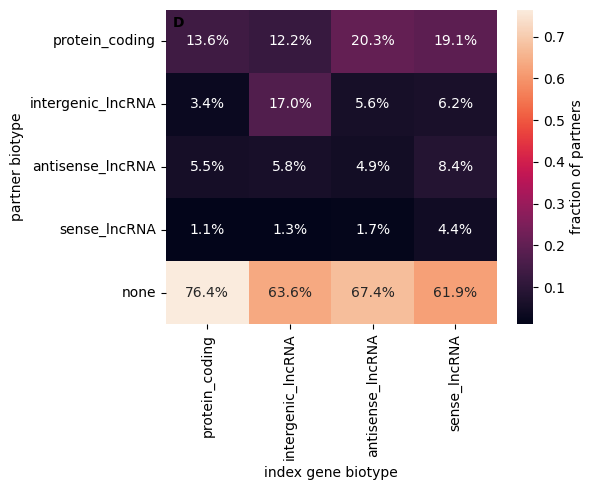

In [66]:
# Exclude 'artifact' from both index and partner biotypes
biotype_order = ['protein_coding', 'lncRNA','intergenic_lncRNA', 'antisense_lncRNA', 'sense_lncRNA', 'none']

# Filter and group data
mat = (
    pairs[
        (pairs['index_biotype'] != 'artifact') &
        (pairs['partner_biotype'] != 'artifact')
    ]
    .groupby(['index_biotype', 'partner_biotype'], as_index=False)
    .size()
    .pivot(index='partner_biotype', columns='index_biotype', values='size')
    .fillna(0)
)

# Reindex rows and columns to desired order, keeping only those present
mat = mat.reindex(index=[b for b in biotype_order if b in mat.index])
mat = mat.reindex(columns=[b for b in biotype_order if b in mat.columns])

# Normalize by index_biotype (columns sum to 1)
mat_prop = mat.div(mat.sum(axis=0), axis=1)

# Format annotation labels as percentages with one decimal place
annot_perc = mat_prop.applymap(lambda x: f"{x*100:.1f}%" if pd.notnull(x) else "")

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    mat_prop, cmap='rocket', annot=annot_perc, fmt='', 
    cbar_kws={'label': 'fraction of partners'}
)
ax.set(xlabel='index gene biotype', ylabel='partner biotype')
ax.text(0.02, 0.98, 'D', transform=ax.transAxes, ha='left', va='top', fontweight='bold')
plt.tight_layout()

/local/scratch/klawren/slrmtmp.48890488/ipykernel_16887/3718235588.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


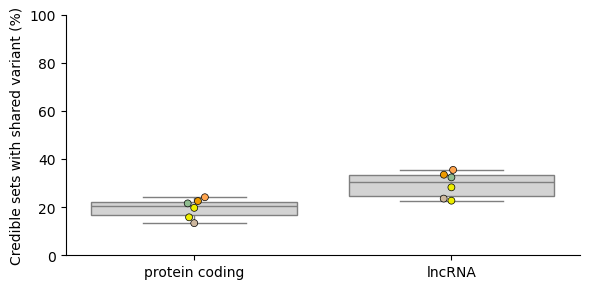

In [72]:
# Collapse all lncRNA biotypes into a single 'lncRNA' category, keep 'protein_coding' as is
cs_biotype_map = {
    'protein_coding': 'protein_coding',
    'antisense_lncRNA': 'lncRNA',
    'intergenic_lncRNA': 'lncRNA',
    'sense_lncRNA': 'lncRNA',
    'other_lncRNA': 'lncRNA',
    'overlapping_both_strands_lncRNA': 'lncRNA'
}
collapsed_biotype_order = [
    'protein_coding',
    'lncRNA'
]

# Map biotypes and filter to relevant ones
subset = cs_level[cs_level['index_biotype'].isin(cs_biotype_map.keys())].copy()
subset['collapsed_biotype'] = subset['index_biotype'].map(cs_biotype_map)

# Calculate share rate per tissue and collapsed biotype
tissue_rate = (
    subset.groupby(['tissue_id', 'collapsed_biotype'], as_index=False)['cs_has_shared_variants']
    .mean()
    .rename(columns={'cs_has_shared_variants': 'share_rate'})
)
tissue_rate['share_rate'] = tissue_rate['share_rate'] * 100

# Use simple biotype labels without sample sizes
biotype_labels = [b.replace('_', ' ') for b in collapsed_biotype_order]

fig, ax = plt.subplots(figsize=(6, 3))

# Boxplot with x as collapsed biotype and y as share rate (rotated 90 degrees)
ax = sns.boxplot(
    data=tissue_rate,
    x='collapsed_biotype', y='share_rate',
    order=collapsed_biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with x as collapsed biotype and y as share rate
sns.swarmplot(
    data=tissue_rate,
    x='collapsed_biotype', y='share_rate',
    order=collapsed_biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_xlabel('')
ax.set_ylabel('Credible sets with shared variant (%)')
ax.set_xticklabels(
    biotype_labels,
    ha='center',
)
ax.set_ylim(0, 100)
sns.despine()
plt.tight_layout()

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/1750430670.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


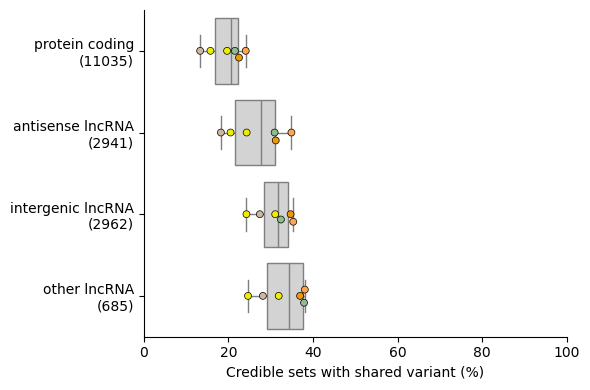

In [232]:
# Collapse 'sense_lncRNA' into 'other_lncRNA' and 'overlapping_both_strands_lncRNA' into 'antisense_lncRNA'
cs_biotype_map = {
    'protein_coding': 'protein_coding',
    'antisense_lncRNA': 'antisense_lncRNA',
    'intergenic_lncRNA': 'intergenic_lncRNA',
    'sense_lncRNA': 'other_lncRNA',
    'other_lncRNA': 'other_lncRNA',
    'overlapping_both_strands_lncRNA': 'antisense_lncRNA'
}
collapsed_biotype_order = [
    'protein_coding',
    'antisense_lncRNA',
    'intergenic_lncRNA',
    'other_lncRNA'
]

# Map biotypes and filter to relevant ones
subset = cs_level[cs_level['index_biotype'].isin(cs_biotype_map.keys())].copy()
subset['collapsed_biotype'] = subset['index_biotype'].map(cs_biotype_map)

# Calculate share rate per tissue and collapsed biotype
tissue_rate = (
    subset.groupby(['tissue_id', 'collapsed_biotype'], as_index=False)['cs_has_shared_variants']
    .mean()
    .rename(columns={'cs_has_shared_variants': 'share_rate'})
)
tissue_rate['share_rate'] = tissue_rate['share_rate'] * 100

# Calculate number of genes per collapsed biotype for labeling
biotype_counts = (
    subset.groupby('collapsed_biotype')['phenotype_id']
    .nunique()
    .reindex(collapsed_biotype_order)
)
biotype_labels = [
    f"{b.replace('_', ' ')}\n({biotype_counts[b]})" for b in collapsed_biotype_order
]

fig, ax = plt.subplots(figsize=(6, 4))

# Boxplot with y as collapsed biotype and x as share rate, protein_coding first
ax = sns.boxplot(
    data=tissue_rate,
    y='collapsed_biotype', x='share_rate',
    order=collapsed_biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with y as collapsed biotype and x as share rate, protein_coding first
sns.swarmplot(
    data=tissue_rate,
    y='collapsed_biotype', x='share_rate',
    order=collapsed_biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_ylabel('')
ax.set_xlabel('Credible sets with shared variant (%)')
ax.set_yticklabels(
    biotype_labels,
    ha='right', rotation=0
)
ax.set_xlim(0, 100)
sns.despine()
plt.tight_layout()

In [94]:
# Find the lead variant (highest pip) for each cs_key and keep biotype and lncRNA category information
lead_variant_cols = [
    'tissue_id', 'phenotype_id', 'cs_id', 'variant_id', 'biotype',
]
susie_lead_variant_df = (
    esusie_df
    .sort_values('pip', ascending=False)
    .groupby(['tissue_id', 'phenotype_id', 'cs_id'], as_index=False)
    .first()[lead_variant_cols]
    .rename(columns={'variant_id': 'lead_variant_id'})
)

In [98]:
lead_shared = susie_lead_variant_df.groupby(['tissue_id', 'lead_variant_id']).agg({'phenotype_id': list, 'biotype': list})

<Axes: xlabel='num_partners', ylabel='Count'>

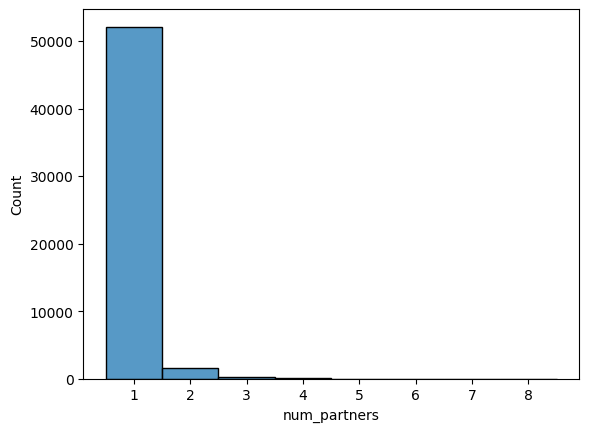

In [106]:
sns.histplot(lead_shared['num_partners'], discrete=True)

/local/scratch/klawren/slrmtmp.48890488/ipykernel_16887/2018291049.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


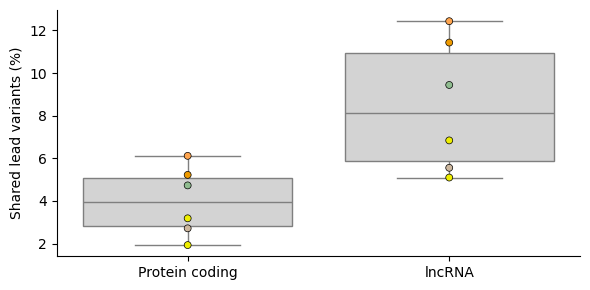

In [108]:
lead_shared['num_partners'] = lead_shared['phenotype_id'].apply(len)
lead_shared_exploded = lead_shared.explode(['phenotype_id', 'biotype'])

# Collapse all lncRNA categories into a single 'lncRNA' category
def collapse_biotype(biotype):
    if biotype == 'protein_coding':
        return 'protein_coding'
    elif 'lncRNA' in str(biotype):
        return 'lncRNA'
    else:
        return None

lead_shared_exploded['collapsed_biotype'] = lead_shared_exploded['biotype'].apply(collapse_biotype)

# Filter to protein_coding and lncRNA only
filtered = lead_shared_exploded[lead_shared_exploded['collapsed_biotype'].isin(['protein_coding', 'lncRNA'])]

# For each tissue and collapsed biotype, compute the percentage with num_partners > 1
summary = (
    filtered
    .groupby(['tissue_id', 'collapsed_biotype'])
    .agg(
        total=('num_partners', 'size'),
        num_gt1=('num_partners', lambda x: (x > 1).sum())
    )
    .reset_index()
)
summary['percent_num_partners_gt1'] = 100 * summary['num_gt1'] / summary['total']

# Set up biotype order and labels for consistent plotting
collapsed_biotype_order = [
    'protein_coding',
    'lncRNA',
]
biotype_labels = [
    'Protein coding',
    'lncRNA',
]

fig, ax = plt.subplots(figsize=(6, 3))

# Boxplot with x as collapsed biotype and y as percent with >1 partners
ax = sns.boxplot(
    data=summary,
    x='collapsed_biotype', y='percent_num_partners_gt1',
    order=collapsed_biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with x as collapsed biotype and y as percent with >1 partners
sns.swarmplot(
    data=summary,
    x='collapsed_biotype', y='percent_num_partners_gt1',
    order=collapsed_biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_xlabel('')
ax.set_ylabel('Shared lead variants (%)')
ax.set_xticklabels(
    biotype_labels,
    ha='center',
)
sns.despine()
plt.tight_layout()


/local/scratch/klawren/slrmtmp.48890488/ipykernel_16887/1085572277.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


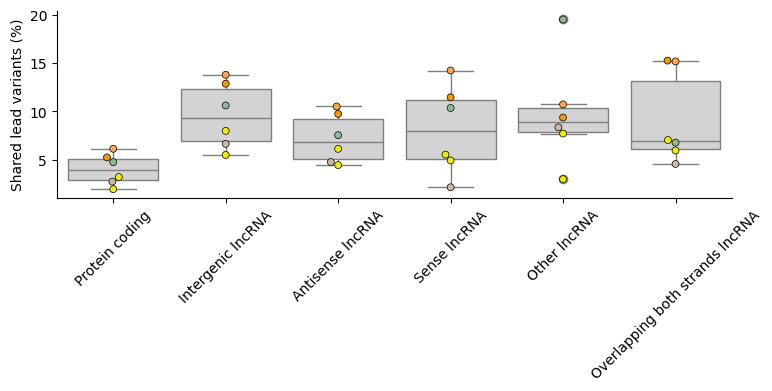

In [110]:
# Filter to protein_coding and all lncRNA subtypes only
lncrna_biotypes = [
    'intergenic_lncRNA',
    'antisense_lncRNA',
    'sense_lncRNA',
    'other_lncRNA',
    'overlapping_both_strands_lncRNA'
]
biotypes_of_interest = ['protein_coding'] + lncrna_biotypes
filtered = lead_shared_exploded[lead_shared_exploded['biotype'].isin(biotypes_of_interest)]

# For each tissue and full (non-collapsed) biotype, compute the percentage with num_partners > 1
summary = (
    filtered
    .groupby(['tissue_id', 'biotype'])
    .agg(
        total=('num_partners', 'size'),
        num_gt1=('num_partners', lambda x: (x > 1).sum())
    )
    .reset_index()
)
summary['percent_num_partners_gt1'] = 100 * summary['num_gt1'] / summary['total']

# Set up biotype order and labels for consistent plotting
biotype_order = ['protein_coding'] + lncrna_biotypes
biotype_labels = [
    'Protein coding',
    'Intergenic lncRNA',
    'Antisense lncRNA',
    'Sense lncRNA',
    'Other lncRNA',
    'Overlapping both strands lncRNA'
]

fig, ax = plt.subplots(figsize=(8, 4))

# Boxplot with x as full biotype and y as percent with >1 partners
ax = sns.boxplot(
    data=summary,
    x='biotype', y='percent_num_partners_gt1',
    order=biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with x as full biotype and y as percent with >1 partners
sns.swarmplot(
    data=summary,
    x='biotype', y='percent_num_partners_gt1',
    order=biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_xlabel('')
ax.set_ylabel('Shared lead variants (%)')
ax.set_xticklabels(
    biotype_labels,
    ha='center',
    rotation=45
)
sns.despine()
plt.tight_layout()


In [121]:
nominal_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL_all_associations"
susie_lead_variant_df['slope'] = np.nan

# Gradually fill in the 'slope' column for cs_level by matching on tissue, gene, and variant
for tissue_id in ['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum']:
    for chr_id in [*range(1, 23), 'X']:
        chr_id = f'chr{chr_id}'
        print(chr_id)
        nominal = pd.read_parquet(f"{nominal_dir}/{tissue_id}.v11.allpairs.{chr_id}.parquet")
        nominal['tissue_id'] = tissue_id

        # Create a mask for rows in cs_level that match this tissue and chromosome, and have missing slope
        mask = (
            (susie_lead_variant_df['tissue_id'] == tissue_id) &
            (susie_lead_variant_df['lead_variant_id'].str.startswith(chr_id)) &
            (susie_lead_variant_df['slope'].isna())
        )

        # Build a mapping from (gene_id, variant_id) to slope for this chunk
        slope_map = nominal.set_index(['gene_id', 'variant_id'])['slope']

        # For each row in susie_lead_variant_df that matches, fill in the slope if available
        idx = susie_lead_variant_df.loc[mask].index
        susie_lead_variant_df.loc[idx, 'slope'] = susie_lead_variant_df.loc[idx].apply(
            lambda row: slope_map.get((row['phenotype_id'], row['lead_variant_id']), row['slope']),
            axis=1
        )
        if chr_id=='chr6':
            break


chr1
chr2
chr3
chr4
chr5
chr6
chr1
chr2
chr3
chr4
chr5
chr6


In [122]:
slope_annotated = susie_lead_variant_df[susie_lead_variant_df['slope'].notna()]
lead_sharing = susie_lead_variant_df.groupby(['tissue_id', 'lead_variant_id']).agg({'phenotype_id': list, 'biotype': list})
lead_sharing.head()

phenotype_id  \
tissue_id            lead_variant_id                                 
Adipose_Subcutaneous chr10_100011477_C_G_b38  [ENSG00000107554.17]   
                     chr10_100133539_G_T_b38   [ENSG00000230224.1]   
                     chr10_100134368_G_T_b38   [ENSG00000305493.1]   
                     chr10_100145864_T_C_b38   [ENSG00000227492.3]   
                     chr10_100155872_C_T_b38  [ENSG00000107593.17]   

                                                          biotype  
tissue_id            lead_variant_id                               
Adipose_Subcutaneous chr10_100011477_C_G_b38     [protein_coding]  
                     chr10_100133539_G_T_b38         [pseudogene]  
                     chr10_100134368_G_T_b38  [intergenic_lncRNA]  
                     chr10_100145864_T_C_b38   [antisense_lncRNA]  
                     chr10_100155872_C_T_b38     [protein_coding]

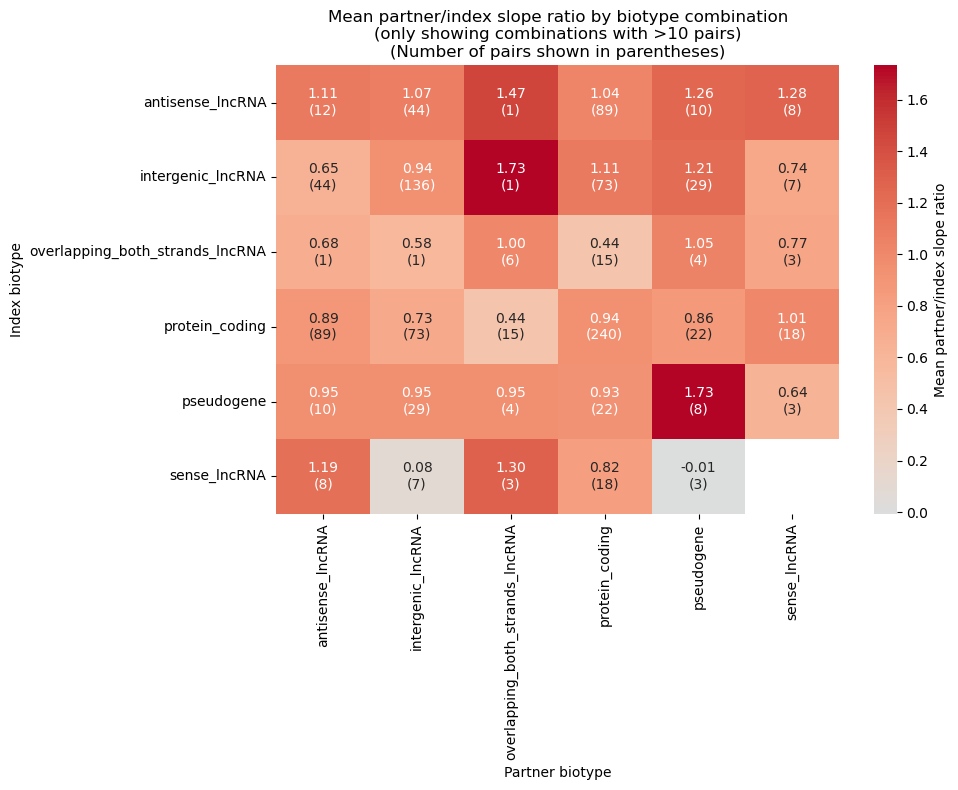

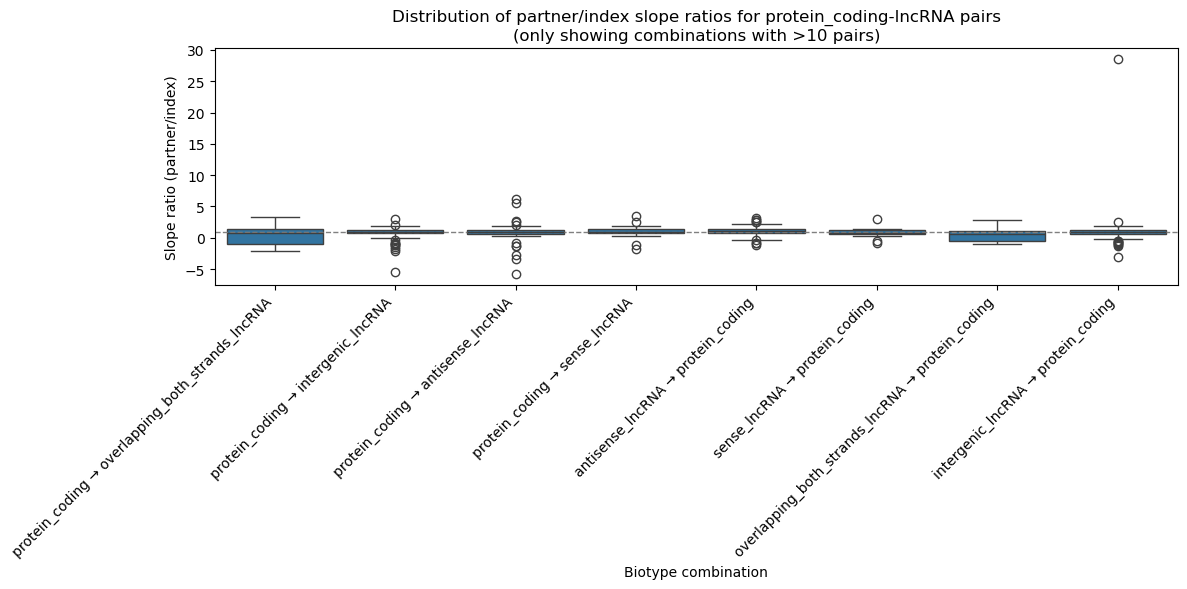

In [126]:
# Efficiently compute slope ratios between index and partner genes for each lead variant

# Merge slope and biotype info for all genes
slope_biotype = slope_annotated[['tissue_id', 'lead_variant_id', 'phenotype_id', 'biotype', 'slope']]

# Self-join on tissue_id and lead_variant_id to get all gene pairs per lead
pairs = slope_biotype.merge(
    slope_biotype,
    on=['tissue_id', 'lead_variant_id'],
    suffixes=('_index', '_partner')
)

# Exclude self-pairs (index gene == partner gene)
pairs = pairs[pairs['phenotype_id_index'] != pairs['phenotype_id_partner']]

# Compute slope ratio, avoiding division by zero and NaN
pairs = pairs[
    (pairs['slope_index'] != 0) &
    (~pairs['slope_index'].isna()) &
    (~pairs['slope_partner'].isna())
].copy()
pairs['slope_ratio'] = pairs['slope_partner'] / pairs['slope_index']

# Prepare DataFrame for plotting
ratio_df = pairs[['biotype_index', 'biotype_partner', 'slope_index', 'slope_partner', 'slope_ratio']]
ratio_df = ratio_df.rename(columns={'biotype_index': 'index_biotype', 'biotype_partner': 'partner_biotype'})

# Count number of pairs for each biotype combination
combo_counts = ratio_df.groupby(['index_biotype', 'partner_biotype']).size().unstack(fill_value=0)

# Only keep biotype combinations with more than 10 pairs
valid_combos = combo_counts[combo_counts > 10].stack().index.tolist()
valid_index_biotypes = set([i for i, j in valid_combos])
valid_partner_biotypes = set([j for i, j in valid_combos])

# Filter ratio_df to only include valid combinations
filtered_ratio_df = ratio_df[
    ratio_df['index_biotype'].isin(valid_index_biotypes) &
    ratio_df['partner_biotype'].isin(valid_partner_biotypes)
]

# For heatmap, only keep rows/columns where at least one cell has >10 pairs
heatmap_counts = filtered_ratio_df.groupby(['index_biotype', 'partner_biotype']).size().unstack(fill_value=0)
heatmap_mask = heatmap_counts > 10
rows_with_valid = heatmap_mask.any(axis=1)
cols_with_valid = heatmap_mask.any(axis=0)
heatmap_index_biotypes = heatmap_counts.index[rows_with_valid]
heatmap_partner_biotypes = heatmap_counts.columns[cols_with_valid]

# Compute the mean ratio for each index_biotype/partner_biotype combination (filtered)
heatmap_data = filtered_ratio_df.groupby(['index_biotype', 'partner_biotype'])['slope_ratio'].mean().unstack()
heatmap_data = heatmap_data.loc[heatmap_index_biotypes, heatmap_partner_biotypes]

# Prepare annotation matrix: show mean slope ratio and number of pairs in each cell
heatmap_counts_filtered = heatmap_counts.loc[heatmap_index_biotypes, heatmap_partner_biotypes]
def make_annot(ratio_mat, count_mat):
    annot = ratio_mat.copy().astype(str)
    for i in ratio_mat.index:
        for j in ratio_mat.columns:
            if pd.notnull(ratio_mat.loc[i, j]) and count_mat.loc[i, j] > 0:
                annot.loc[i, j] = f"{ratio_mat.loc[i, j]:.2f}\n({count_mat.loc[i, j]})"
            else:
                annot.loc[i, j] = ""
    return annot

annot_mat = make_annot(heatmap_data, heatmap_counts_filtered)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    annot=annot_mat,
    fmt="",
    cmap="coolwarm",
    center=0,
    cbar_kws={'label': 'Mean partner/index slope ratio'}
)
plt.title('Mean partner/index slope ratio by biotype combination\n(only showing combinations with >10 pairs)\n(Number of pairs shown in parentheses)')
plt.xlabel('Partner biotype')
plt.ylabel('Index biotype')
plt.tight_layout()
plt.show()

# Boxplot for protein_coding-lncRNA combinations (only if >10 pairs)
lncrna_types = [b for b in filtered_ratio_df['partner_biotype'].unique() if 'lncRNA' in b]
pc_lncrna_df = filtered_ratio_df[
    ((filtered_ratio_df['index_biotype'] == 'protein_coding') & (filtered_ratio_df['partner_biotype'].isin(lncrna_types))) |
    ((filtered_ratio_df['partner_biotype'] == 'protein_coding') & (filtered_ratio_df['index_biotype'].isin(lncrna_types)))
].copy()

# Only keep combos with >10 pairs
combo_counts_box = pc_lncrna_df.groupby(['index_biotype', 'partner_biotype']).size()
valid_combos_box = combo_counts_box[combo_counts_box > 10].index.tolist()
def is_valid_combo(row):
    return (row['index_biotype'], row['partner_biotype']) in valid_combos_box or \
           (row['partner_biotype'], row['index_biotype']) in valid_combos_box
pc_lncrna_df = pc_lncrna_df[pc_lncrna_df.apply(is_valid_combo, axis=1)]

def combo_label(row):
    if row['index_biotype'] == 'protein_coding':
        return f"protein_coding → {row['partner_biotype']}"
    else:
        return f"{row['index_biotype']} → protein_coding"

pc_lncrna_df['combo'] = pc_lncrna_df.apply(combo_label, axis=1)

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=pc_lncrna_df,
    x='combo',
    y='slope_ratio'
)
plt.axhline(1, color='gray', linestyle='--', linewidth=1)
plt.title('Distribution of partner/index slope ratios for protein_coding-lncRNA pairs\n(only showing combinations with >10 pairs)')
plt.xlabel('Biotype combination')
plt.ylabel('Slope ratio (partner/index)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()